In [864]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor

In [865]:
train = pd.read_csv("/content/drive/MyDrive/aiffel/Data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/aiffel/Data/test.csv")
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 22)
sub data dim : (6468, 21)


In [866]:
# 배웠던 것과 동일하게 log 변환을 통해 분포를 정규화 시켜보자
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for i in skew_columns:
    train[i] = np.log1p(train[i].values)

for i in skew_columns:
    test[i] = np.log1p(test[i].values)

In [867]:
train_len = len(train)
data = pd.concat((train, test), axis=0)
sub_id = data['id'][train_len:]

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜(집을 판매한 날짜)
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수(.5는 화장실은 있으나 샤워실은 없는 방)
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도(0~4)
11. condition : 집의 전반적인 상태(1~5)
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
* 1부터13의 지수, 여기서 1,2,3은 건물 구조 및 설계에 미달하고, 7은 평균 수준의 구조 및 설계이며, 11,12,13은 고품질 수준의 구조 및 설계를 나타냅니다.
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 해당 주택을 기준으로 주변 15개 주택의 주거 공간 평균 면적
21. sqft_lot15 : 주변 15개 주택의 부지 면적 평균

*(20,21번 변수는 15년도 시점에서 면적 계산이라는 설명도 있으나, 그렇게 변수를 사용할 시 주거공간이 작아진 데이터가 절반 이상이다.따라서, 위 변수 설명으로 보는게 맞는 것 같다. )


In [868]:
train['price']

,price
0,12.309987
1,12.100718
2,13.142168
3,12.458779
4,12.583999
...,...
15030,13.322338
15031,13.822984
15032,12.793862
15033,12.899222


* pgeocode 라이브러리 설치 후, 우편번호로 도시명을 뽑아냈다.
* 다만, 시간이 오래걸려서 city 변수를 추출, 파일 저장 후, 다시 train,test를 불러왔다. 이 때, `train['price]`는 이미 로그 변환이 되어있는 상태.

In [869]:
# pip install pgeocode

# import pgeocode

# # 미국 우편번호 정보 사용
# nomi = pgeocode.Nominatim('us')

# # 우편번호를 기반으로 도시 이름 가져오기
# def get_city_from_zip(zip_code):
#     location = nomi.query_postal_code(zip_code)
#     return location.place_name if location is not None else None

# # 'city' 열을 추가하여 각 zipcode에 해당하는 도시 이름 저장
# train['city'] = train['zipcode'].apply(get_city_from_zip)

# # 결과 확인
# print(train[['zipcode', 'city']].head())


# # 'city' 열을 추가하여 각 zipcode에 해당하는 도시 이름 저장
# test['city'] = test['zipcode'].apply(get_city_from_zip)

# # 결과 확인
# print(test[['zipcode', 'city']].head())

In [870]:
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

In [871]:
## date는 큰 의미없다.

# train['date'] = train['date'].astype('int64')
# train['date'] = pd.to_datetime(train['date'], format='%Y%m')
# train['year'] = train['date'].dt.year
# train['month'] = train['date'].dt.month
# train = train.drop(columns=['date'])
# test['date'] = test['date'].astype('int64')
# test['date'] = pd.to_datetime(test['date'], format='%Y%m')
# test['year'] = test['date'].dt.year
# test['month'] = test['date'].dt.month
# test = test.drop(columns=['date'])

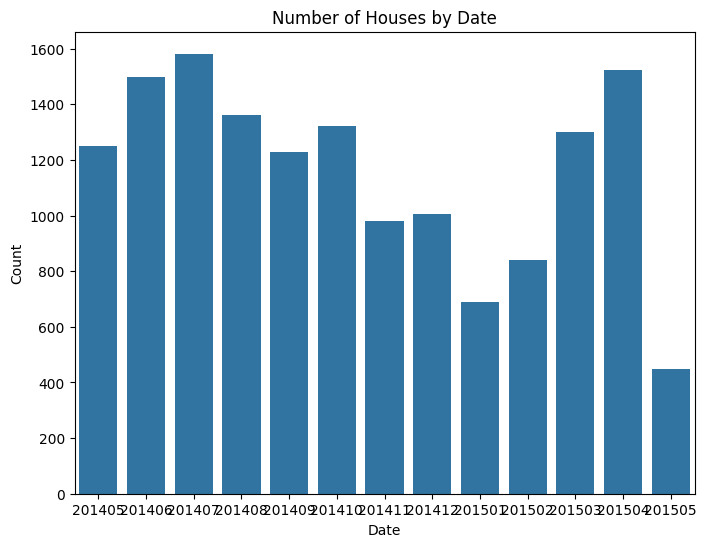

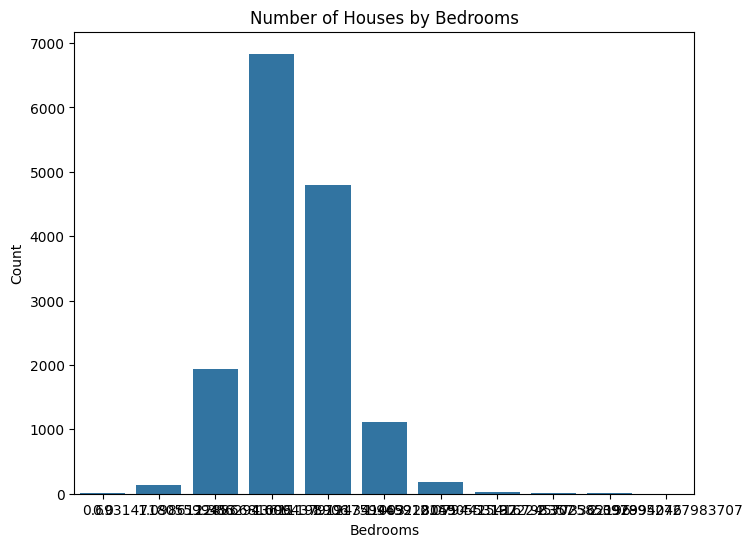

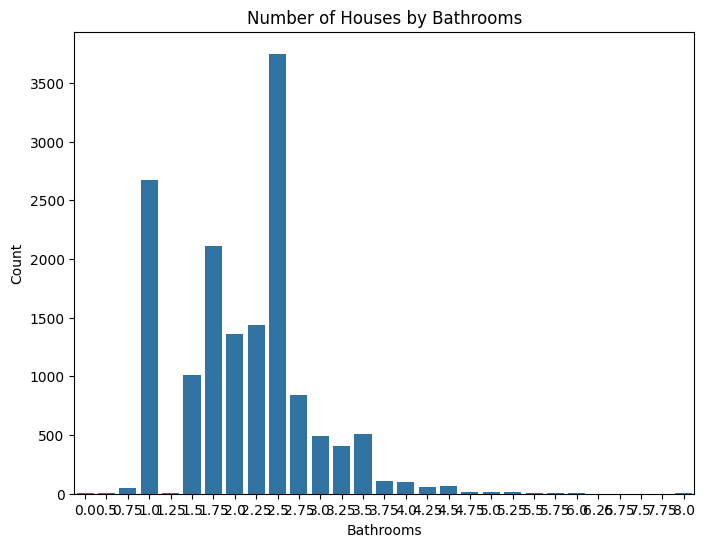

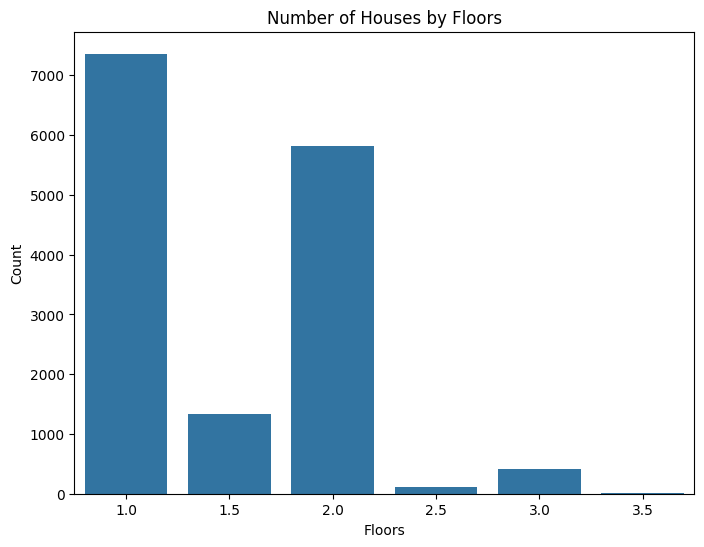

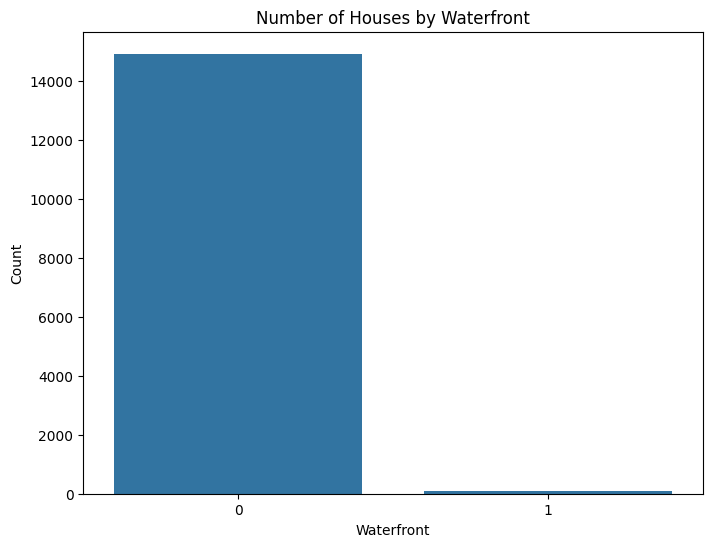

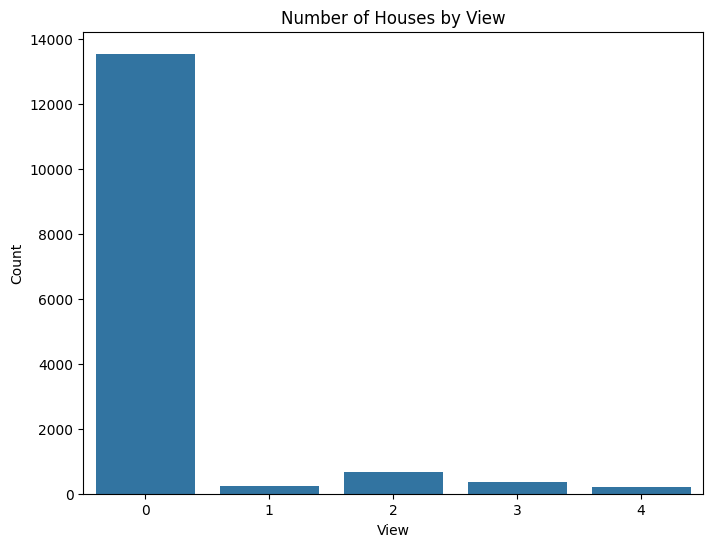

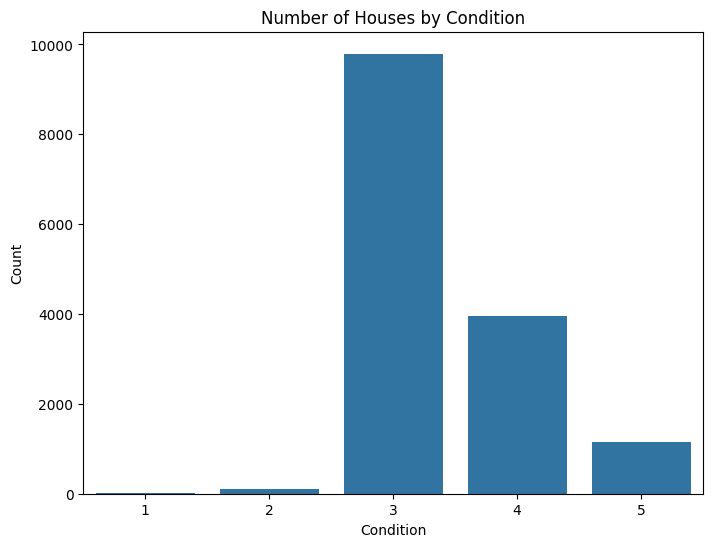

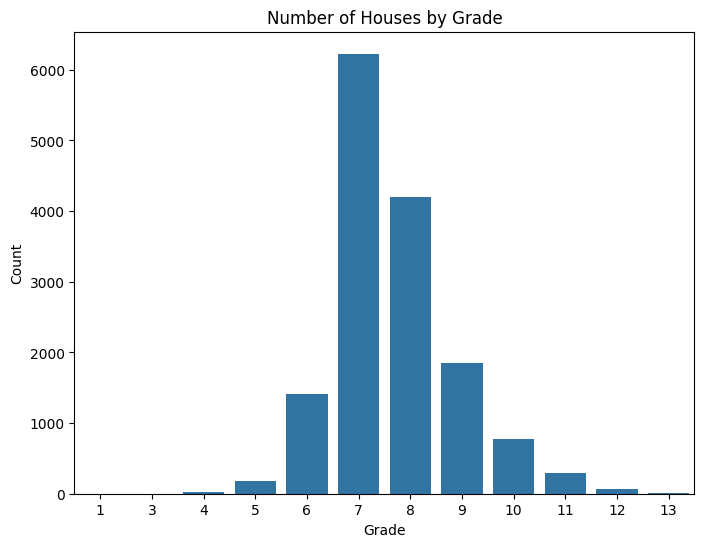

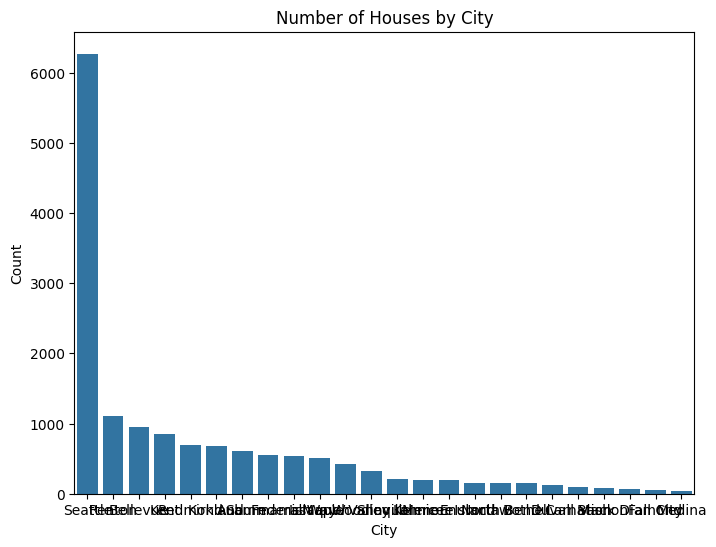

In [872]:
for col in train.columns:
    if train[col].nunique() <= 30:
        plt.figure(figsize=(8, 6))
        sns.barplot(x=train[col].value_counts().index,
                    y=train[col].value_counts().values)
        plt.xlabel(col.capitalize())
        plt.ylabel('Count')
        plt.title(f'Number of Houses by {col.capitalize()}')
        plt.show()

In [873]:
plt.figure(figsize=(15, 80))

for i, col in enumerate(train.columns, 1):
    plt.subplot(len(train.columns), 1, i)
    sns.scatterplot(x=train[col], y=train['price'])
    plt.title(f'Scatter Plot of {col} vs. price')
    plt.xlabel(col)
    plt.ylabel('pirce')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

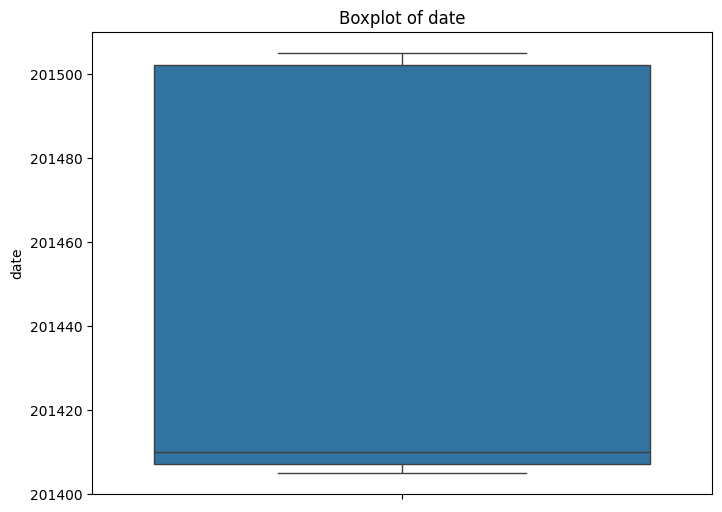

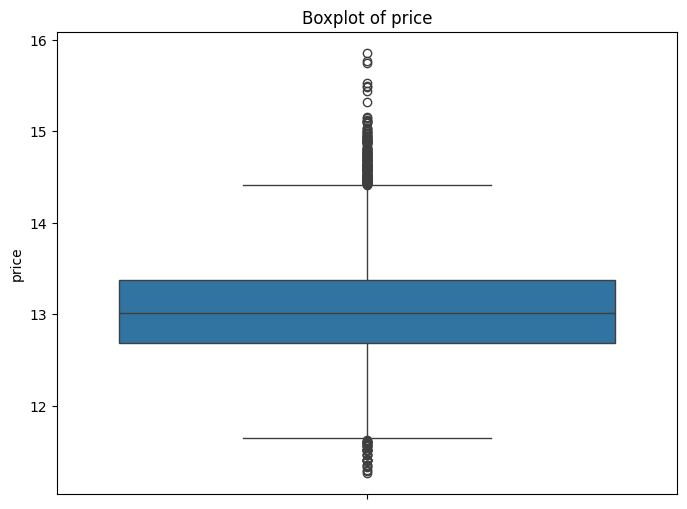

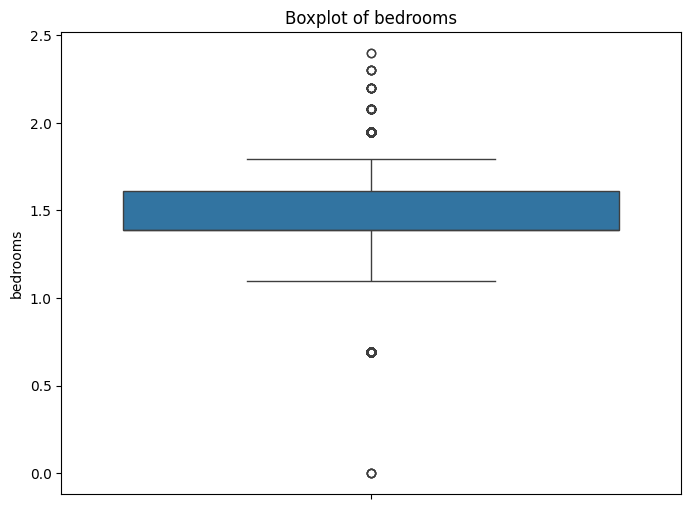

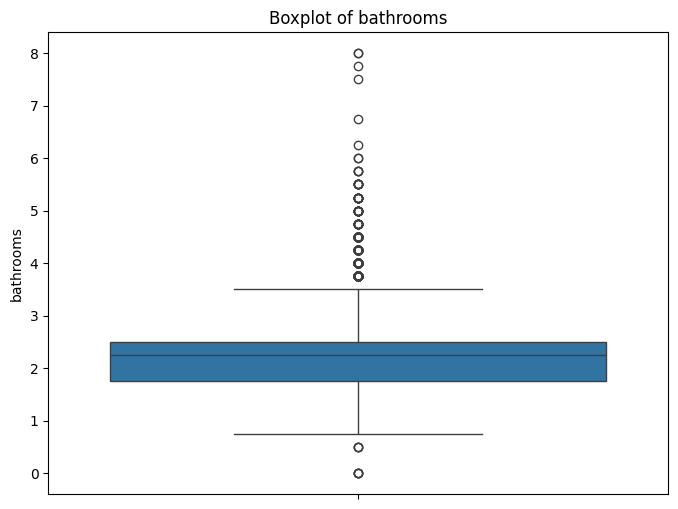

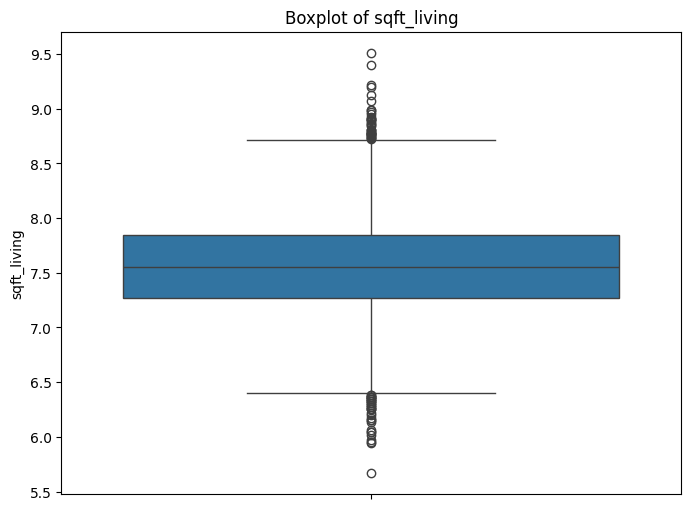

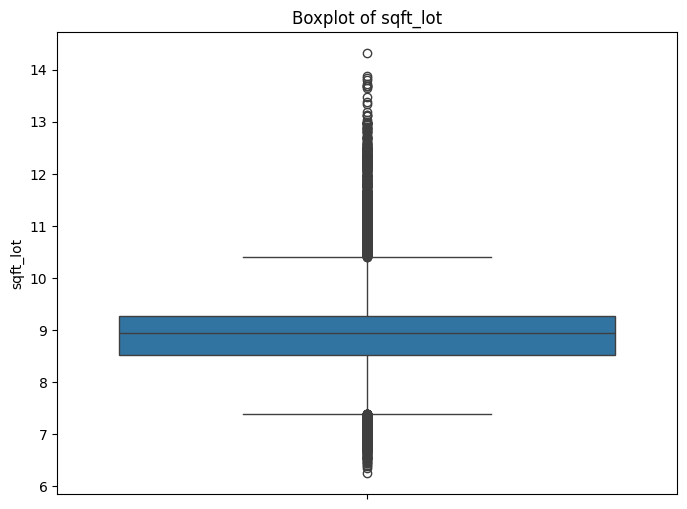

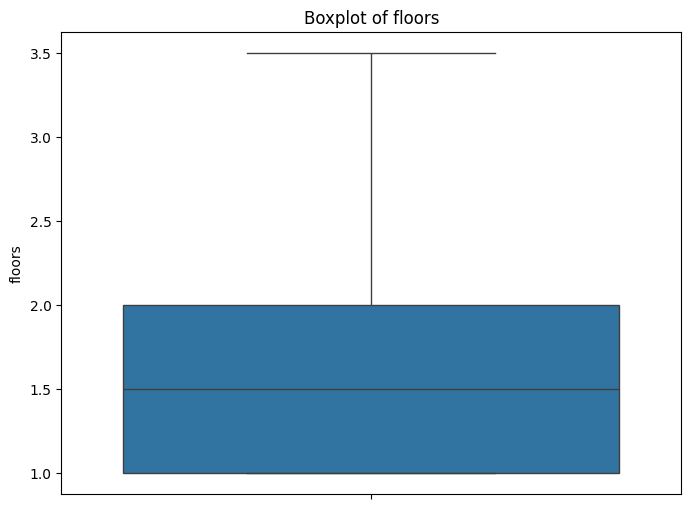

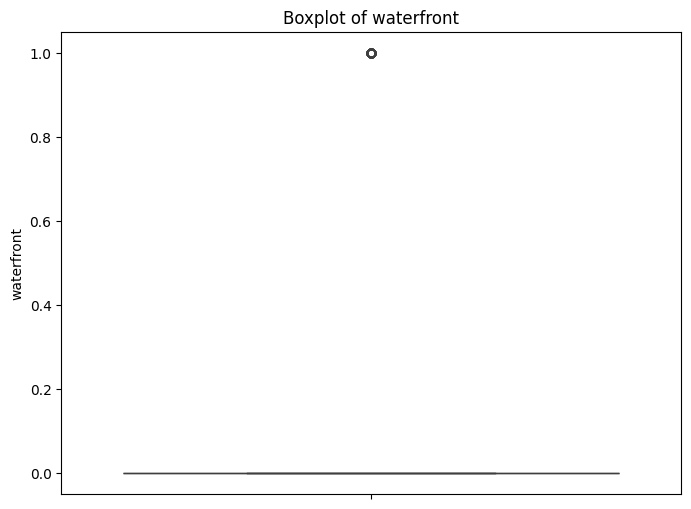

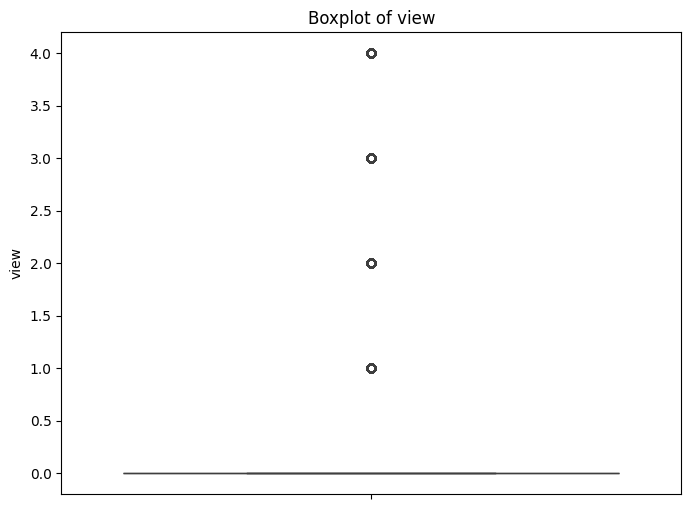

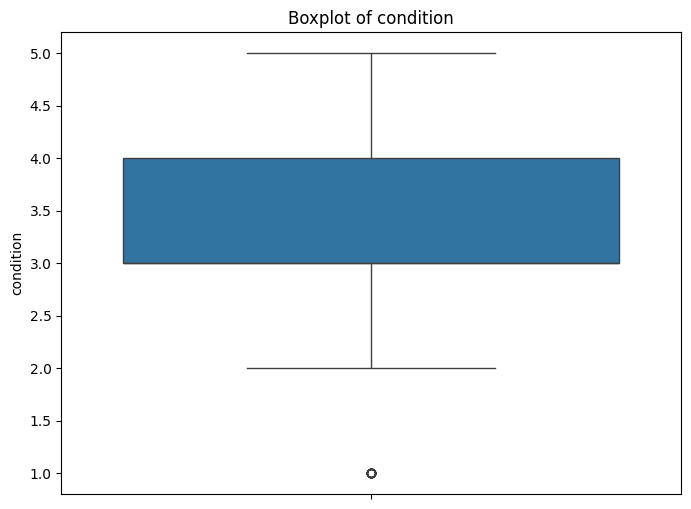

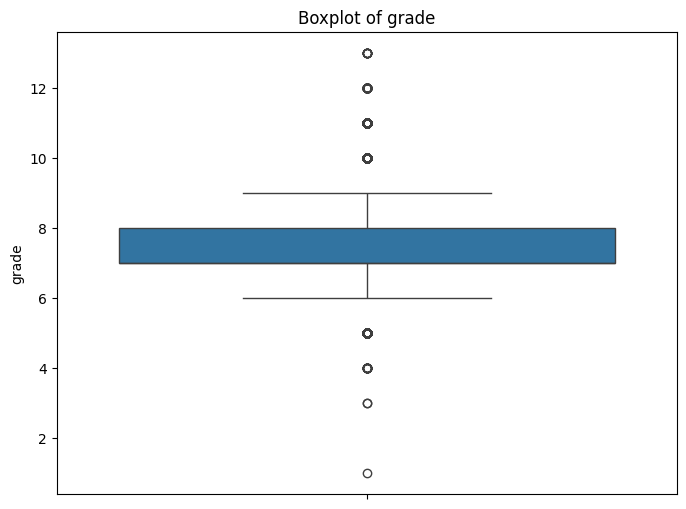

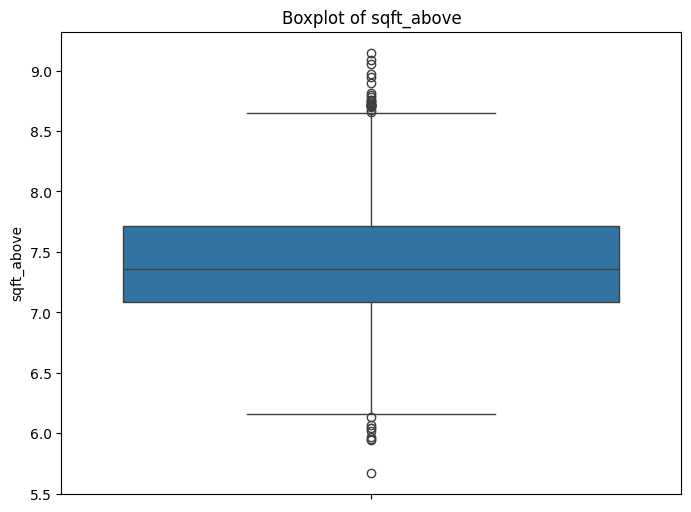

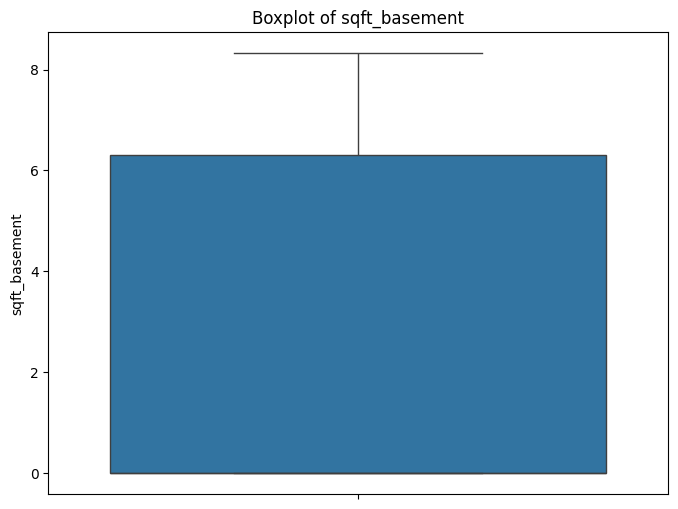

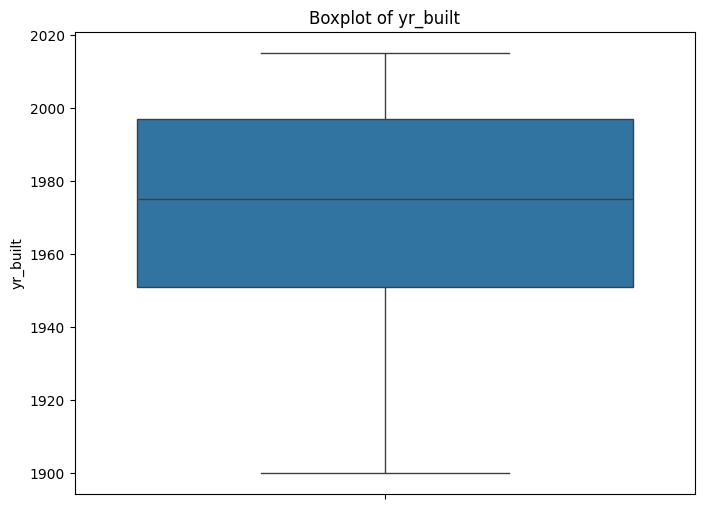

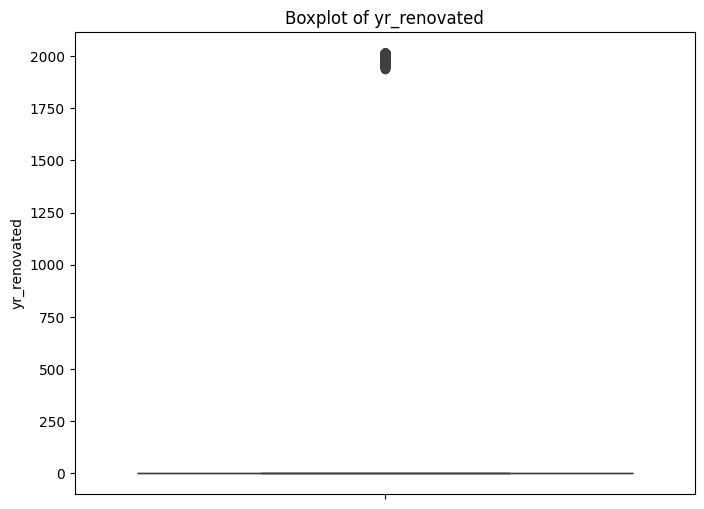

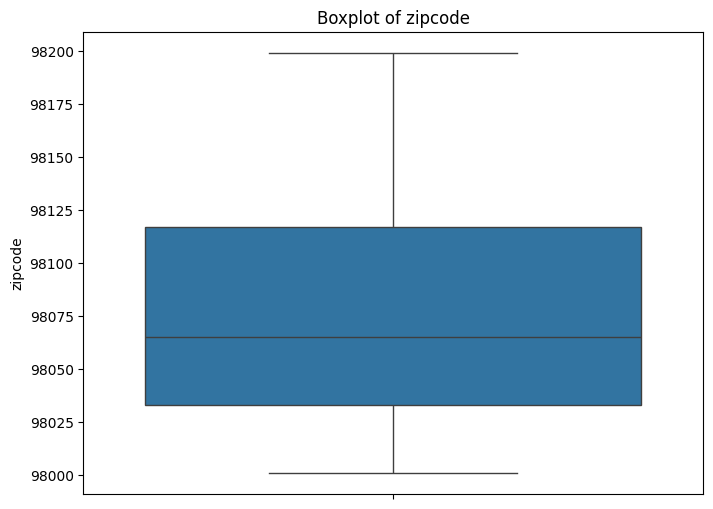

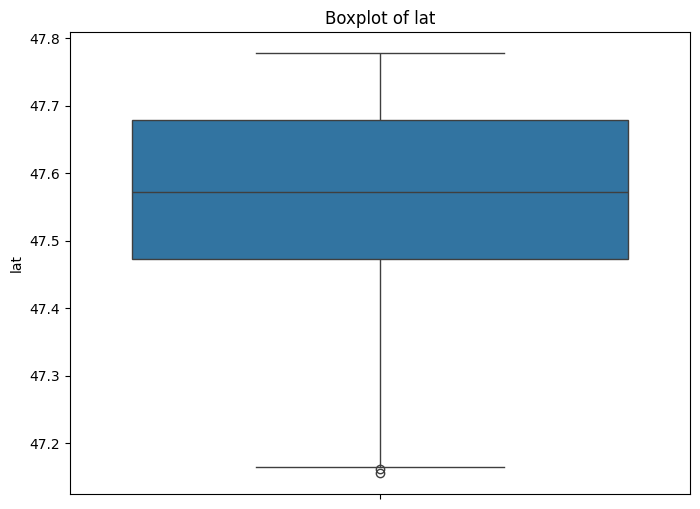

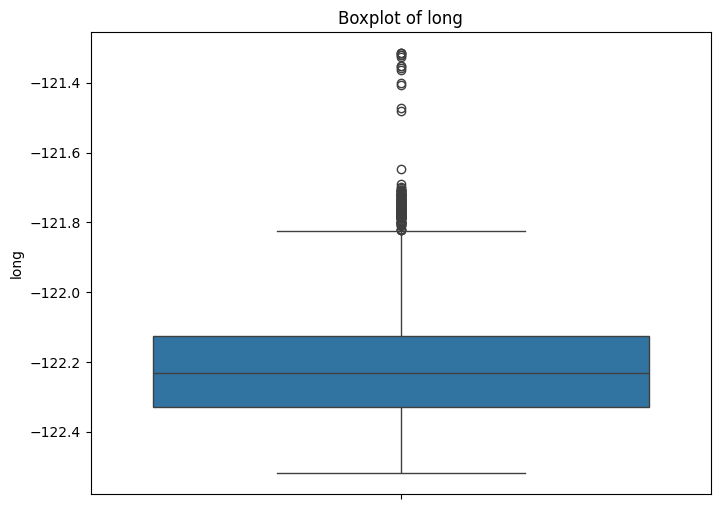

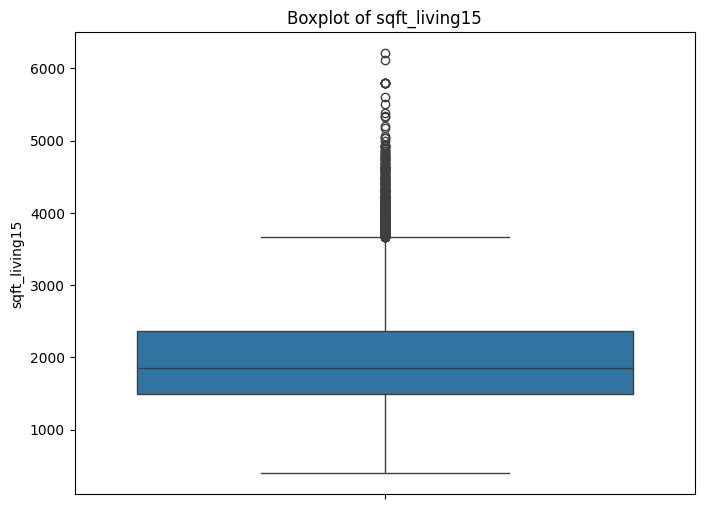

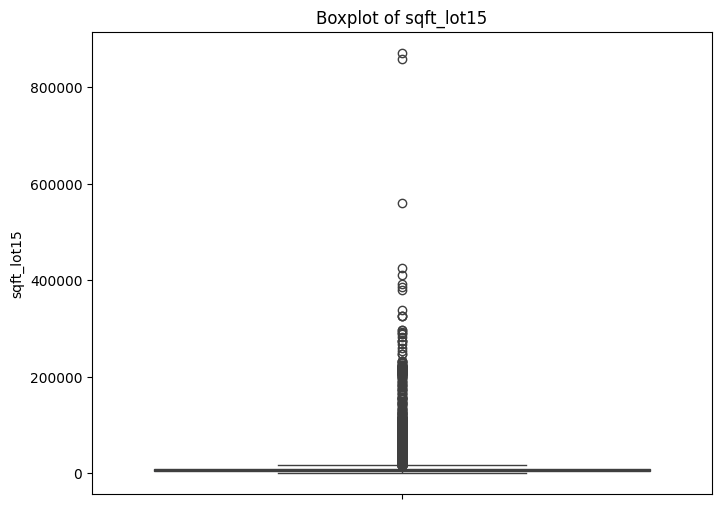

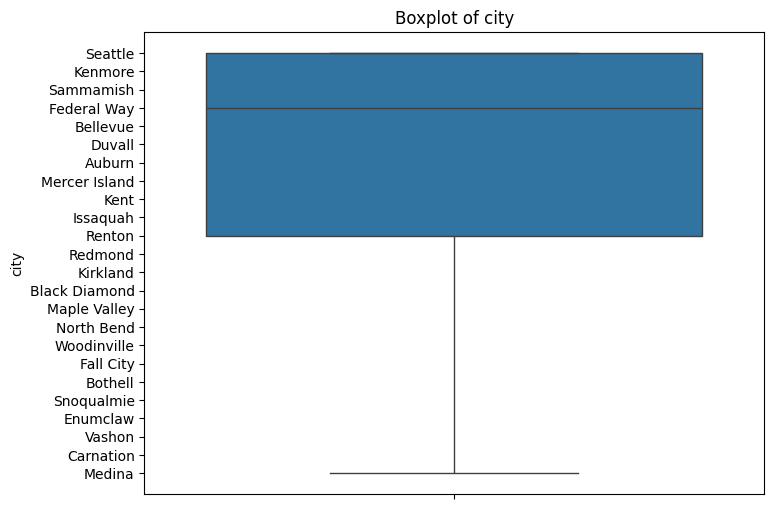

In [874]:
for col in train.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=train, y=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

* 밀도는 의미없다.

In [875]:
## 격자 생성 밀도 뽑아내기

lat_bins = np.linspace(train['lat'].min(), train['lat'].max(), num=100)
long_bins = np.linspace(train['long'].min(), train['long'].max(), num=100)

train['lat_bin'] = np.digitize(train['lat'], bins=lat_bins)
train['long_bin'] = np.digitize(train['long'], bins=long_bins)
test['lat_bin'] = np.digitize(test['lat'], bins=lat_bins)
test['long_bin'] = np.digitize(test['long'], bins=long_bins)

train_density_counts = train.groupby(['lat_bin', 'long_bin']).size().reset_index(name='density')
test_density_counts = test.groupby(['lat_bin', 'long_bin']).size().reset_index(name='density')

# 원본 데이터와 밀도 값을 매칭
train = train.merge(train_density_counts, on=['lat_bin', 'long_bin'], how='left')
test = test.merge(test_density_counts, on=['lat_bin', 'long_bin'], how='left')

# 필요 없는 열 삭제
train.drop(['lat_bin', 'long_bin'], axis=1, inplace=True)
test.drop(['lat_bin', 'long_bin'], axis=1, inplace=True)

train[['lat', 'long', 'density']].head()

,lat,long,density
0,47.5112,-122.257,13
1,47.7379,-122.233,12
2,47.6168,-122.045,15
3,47.3097,-122.327,5
4,47.4095,-122.315,4


### 부촌 특정하기

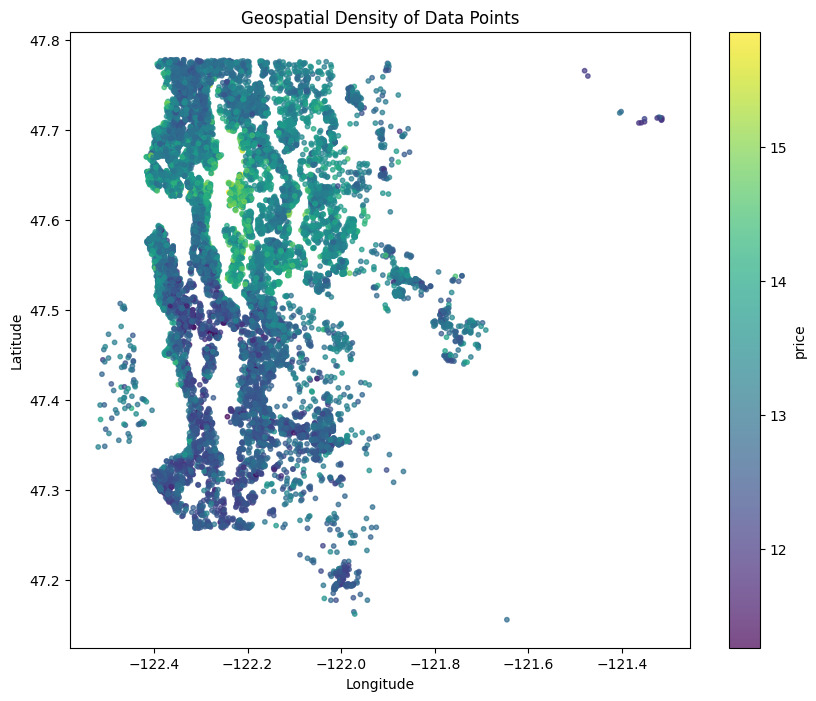

In [876]:
## 밀도에선 insight가 없어서 price를 경위도 격자 위에 뿌려봤다.

plt.figure(figsize=(10, 8))
density_plot = plt.scatter(train['long'], train['lat'], c=train['price'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(density_plot, label='price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Density of Data Points')
plt.show()

In [877]:
train.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'city', 'density'],
      dtype='object')

* price를 써버리면 사실 상 데이터 유출에 가깝다. 선형성이 그나마 강한 sqft_above로 대체

In [878]:
# 경위도를 격자 형태로 변환
grid_size = 0.001  # 격자 크기 (적절히 조정 가능)
train['lat_bin'] = (train['lat'] // grid_size) * grid_size
train['long_bin'] = (train['long'] // grid_size) * grid_size

# 각 평균 계산
grid_avg_sqft_above = train.groupby(['lat_bin', 'long_bin'])['sqft_above'].mean().reset_index()
grid_avg_sqft_above.columns = ['lat_bin', 'long_bin', 'avg_sqft_above']

# 격자 평균 추가
train = train.merge(grid_avg_sqft_above, on=['lat_bin', 'long_bin'], how='left')

train.head()
# 평균이 높으면, 부촌으로
high_sqft_above_threshold = train['avg_sqft_above'].quantile(0.91)  # 상위 9%를 부촌으로 간주
train['is_high_sqft_above_area'] = (train['avg_sqft_above'] >= high_sqft_above_threshold).astype(int)

# test도 train셋에 맞춰서
test['lat_bin'] = (train['lat'] // grid_size) * grid_size
test['long_bin'] = (train['long'] // grid_size) * grid_size

test = test.merge(grid_avg_sqft_above[['lat_bin', 'long_bin', 'avg_sqft_above']], on=['lat_bin', 'long_bin'], how='left')
test['is_high_sqft_above_area'] = (test['avg_sqft_above'] >= high_sqft_above_threshold).astype(int)

test['is_high_sqft_above_area'].fillna(0, inplace=True)

# 필요없는 변수 drop
train = train.drop(columns=['lat_bin', 'long_bin', 'avg_sqft_above'])
test = test.drop(columns=['lat_bin', 'long_bin', 'avg_sqft_above'])

# 결과 확인
print(train[['lat', 'long', 'is_high_sqft_above_area']].head())
print(test[['lat', 'long', 'is_high_sqft_above_area']].head())

       lat     long  is_high_sqft_above_area
0  47.5112 -122.257                        0
1  47.7379 -122.233                        0
2  47.6168 -122.045                        0
3  47.3097 -122.327                        0
4  47.4095 -122.315                        0
       lat     long  is_high_sqft_above_area
0  47.7210 -122.319                        0
1  47.5208 -122.393                        0
2  47.6561 -122.005                        0
3  47.5123 -122.337                        0
4  47.3684 -122.031                        0


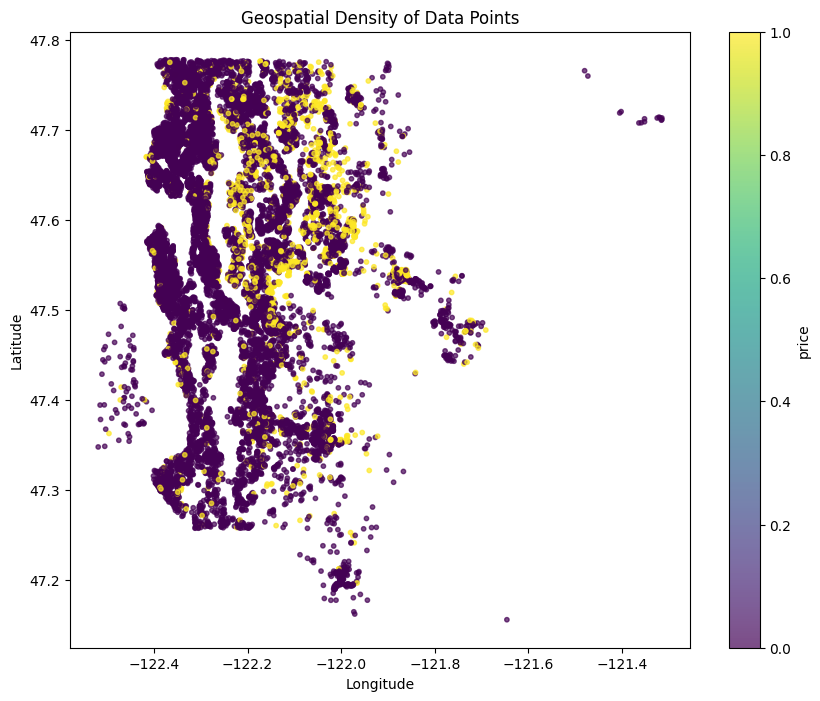

In [879]:
# 보수적으로 잡을수록 성능이 좋아진다.
plt.figure(figsize=(10, 8))
density_plot = plt.scatter(train['long'], train['lat'], c=train['is_high_sqft_above_area'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(density_plot, label='price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Density of Data Points')
plt.show()

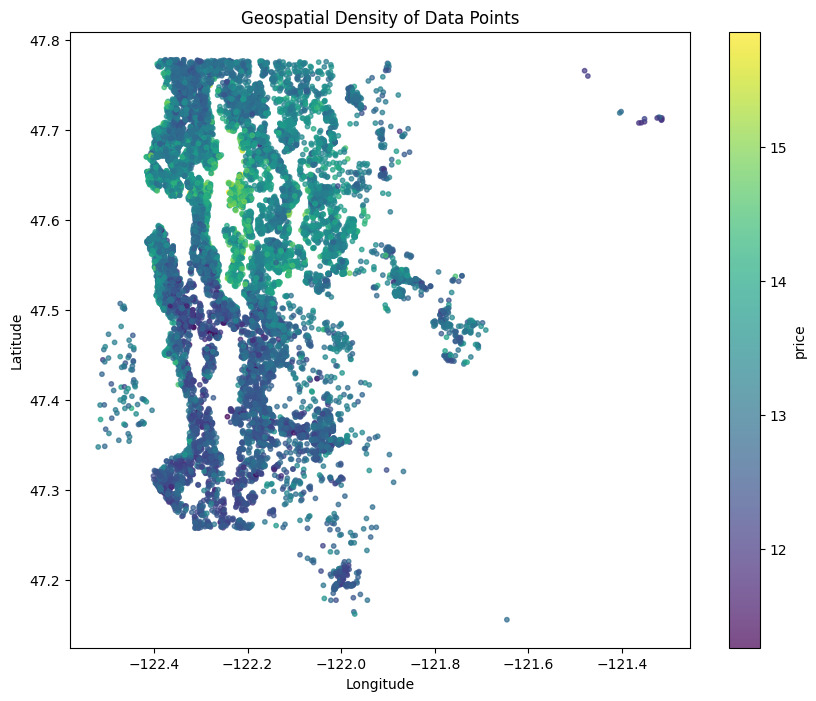

In [880]:
plt.figure(figsize=(10, 8))
density_plot = plt.scatter(train['long'], train['lat'], c=train['price'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(density_plot, label='price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Density of Data Points')
plt.show()

In [881]:
# # 경위도를 격자 형태로 변환
# grid_size = 0.001  # 격자 크기 (적절히 조정 가능)
# train['lat_bin'] = (train['lat'] // grid_size) * grid_size
# train['long_bin'] = (train['long'] // grid_size) * grid_size

# # 각 평균 계산
# grid_avg_price = train.groupby(['lat_bin', 'long_bin'])['price'].mean().reset_index()
# grid_avg_price.columns = ['lat_bin', 'long_bin', 'avg_price']

# # 격자 평균 추가
# train = train.merge(grid_avg_price, on=['lat_bin', 'long_bin'], how='left')

# train.head()
# # 평균 가격이 높으면, 부촌으로
# high_price_threshold = train['avg_price'].quantile(0.91)  # 상위 9%를 부촌으로 간주
# train['is_high_price_area'] = (train['avg_price'] >= high_price_threshold).astype(int)

# # test도 train셋에 맞춰서
# test['lat_bin'] = (train['lat'] // grid_size) * grid_size
# test['long_bin'] = (train['long'] // grid_size) * grid_size

# test = test.merge(grid_avg_price[['lat_bin', 'long_bin', 'avg_price']], on=['lat_bin', 'long_bin'], how='left')
# test['is_high_price_area'] = (test['avg_price'] >= high_price_threshold).astype(int)

# test['is_high_price_area'].fillna(0, inplace=True)

# # 필요없는 변수 drop
# train = train.drop(columns=['lat_bin', 'long_bin', 'avg_price'])
# test = test.drop(columns=['lat_bin', 'long_bin', 'avg_price'])

# # 결과 확인
# print(train[['lat', 'long', 'is_high_price_area']].head())
# print(test[['lat', 'long', 'is_high_price_area']].head())

In [882]:
train['is_high_sqft_above_area'].value_counts()

,count
is_high_sqft_above_area,
0,13513
1,1522


In [883]:
test['is_high_sqft_above_area'].value_counts()

,count
is_high_sqft_above_area,
0,5860
1,608


### 도시(city)

In [884]:
# # 도시별 상위 10%를 부촌으로 간주하고, 각 도시에 대해 개별 열 생성
# cities = train['city'].unique()  # 모든 도시의 리스트를 추출

# for city in cities:
#     # 각 도시의 상위 10%를 계산하여 부촌 여부 판단
#     high_price_threshold = train[train['city'] == city]['price'].quantile(0.95)
#     train[f'high_price_{city}'] = (train['price'] >= high_price_threshold).astype(int)
#     test[f'high_price_{city}'] = (train['price'] >= high_price_threshold).astype(int)

# # 결과 확인
# print(train[[f'high_price_{city}' for city in cities]].head())
# print(test[[f'high_price_{city}' for city in cities]].head())

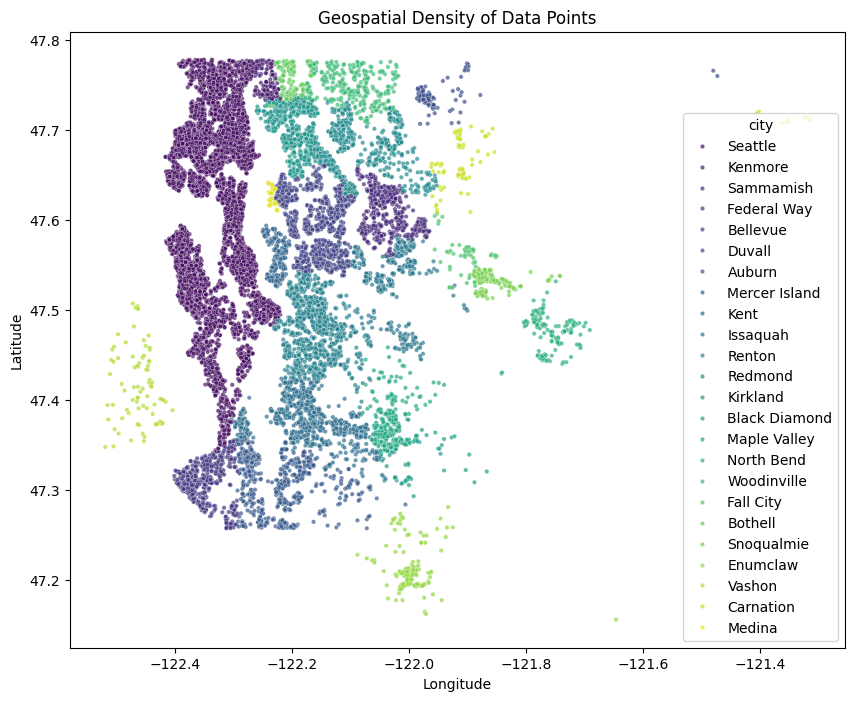

In [885]:
## 도시 이름 별 분포를 확인해보자
plt.figure(figsize=(10, 8))
sns.scatterplot(x='long', y='lat', hue='city', data=train, palette='viridis', s=10, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Density of Data Points')
plt.show()

In [886]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     15035 non-null  int64  
 1   price                    15035 non-null  float64
 2   bedrooms                 15035 non-null  float64
 3   bathrooms                15035 non-null  float64
 4   sqft_living              15035 non-null  float64
 5   sqft_lot                 15035 non-null  float64
 6   floors                   15035 non-null  float64
 7   waterfront               15035 non-null  int64  
 8   view                     15035 non-null  int64  
 9   condition                15035 non-null  int64  
 10  grade                    15035 non-null  int64  
 11  sqft_above               15035 non-null  float64
 12  sqft_basement            15035 non-null  float64
 13  yr_built                 15035 non-null  int64  
 14  yr_renovated          

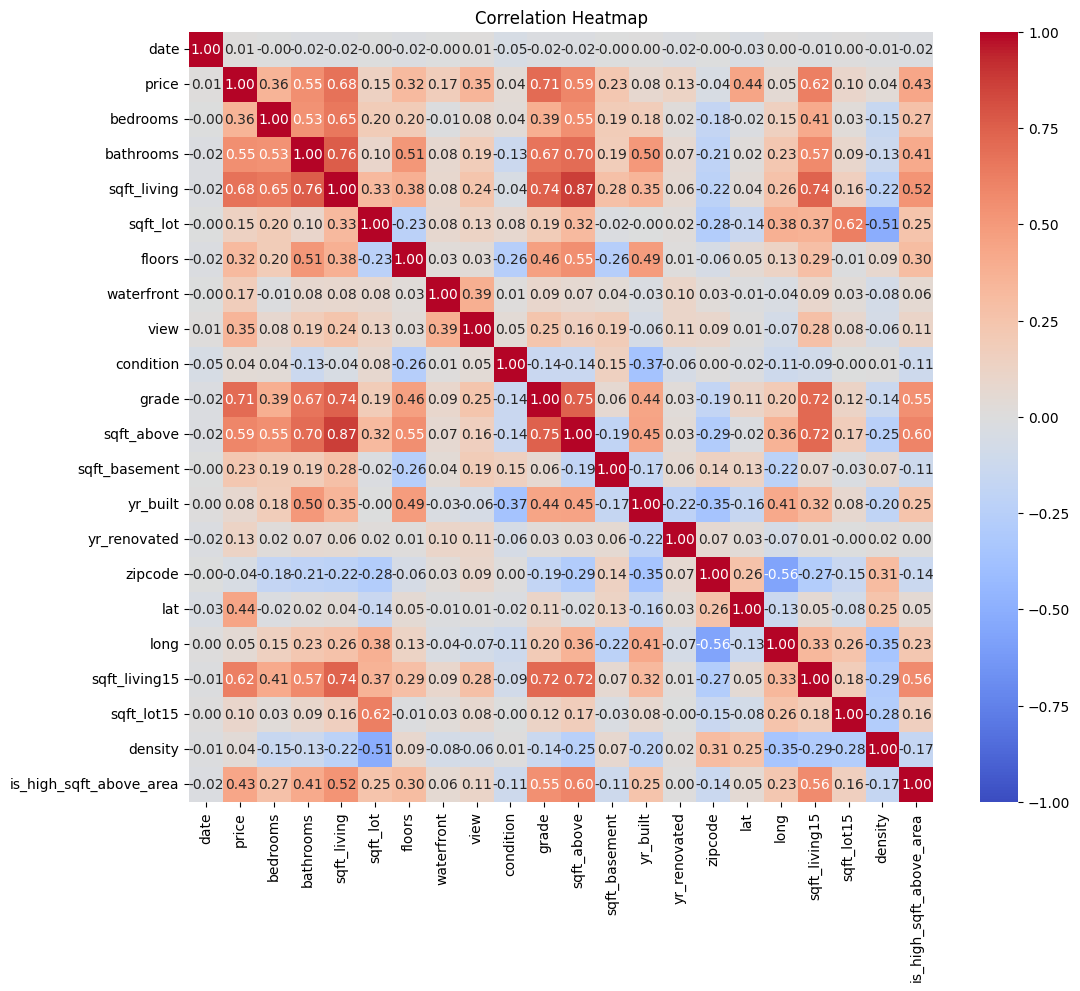

In [887]:
# 상관 행렬
corr_matrix = train.drop(columns=['city']).corr()

# 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [888]:
# 다중공선성 검증
vif_data = pd.DataFrame()
vif_data["feature"] = train.drop(columns=['city']).columns

# 분산팽창
vif_data["VIF"] = [variance_inflation_factor(train.drop(columns=['city']).values, i) for i in range(train.drop(columns=['city']).shape[1])]

print(vif_data)

                    feature           VIF
0                      date  3.971133e+06
1                     price  2.820152e+03
2                  bedrooms  9.449131e+01
3                 bathrooms  2.883973e+01
4               sqft_living  8.663538e+03
5                  sqft_lot  3.110256e+02
6                    floors  2.236867e+01
7                waterfront  1.226520e+00
8                      view  1.571961e+00
9                 condition  3.684814e+01
10                    grade  1.709895e+02
11               sqft_above  7.971789e+03
12            sqft_basement  1.081655e+01
13                 yr_built  1.165432e+04
14             yr_renovated  1.207170e+00
15                  zipcode  5.040008e+06
16                      lat  2.092303e+05
17                     long  1.418740e+06
18            sqft_living15  2.935255e+01
19               sqft_lot15  2.205197e+00
20                  density  4.946742e+00
21  is_high_sqft_above_area  1.916771e+00


In [889]:
train.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'city', 'density',
       'is_high_sqft_above_area'],
      dtype='object')

In [890]:
test.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'city', 'density',
       'is_high_sqft_above_area'],
      dtype='object')

In [891]:
!pip install folium

In [892]:
print(train['lat'].mean())
print(train['long'].mean())

47.5607206185567
-122.21367682075159


In [893]:
# from geopy.distance import geodesic

# # 중심 좌표 계산 (평균 경위도)
# center_coords = (train['lat'].mean(), train['long'].mean())

# # 각 지점에서 중심까지의 거리 계산
# train['distance_from_center'] = train.apply(lambda row: geodesic(center_coords, (row['lat'], row['long'])).kilometers, axis=1)

# # 최대 거리 계산 (반경)
# max_distance = train['distance_from_center'].max()
# print("반경 (최대 거리):", max_distance, "km")

In [894]:
# import folium

# # 지도 초기화: train 데이터의 경위도 평균을 중심으로 설정
# price_map = folium.Map(location=[train['lat'].mean(), train['long'].mean()], zoom_start=12)

# # train 데이터의 각 지점을 지도에 마커로 추가
# for i in train.index:
#     # 각 지점의 price 값 생성
#     price_name = f"Price: {train.loc[i, 'price']}"  # 가격을 popup에 표시할 텍스트로 설정
#     popup = folium.Popup(price_name, max_width=500)

#     # 마커 추가: 각 지점의 경위도를 기반으로 위치 설정
#     folium.Marker(
#         location=[train.loc[i, 'lat'], train.loc[i, 'long']],
#         popup=popup
#     ).add_to(price_map)

# # 지도를 출력
# price_map

In [895]:
# # 상위 7%

# import folium
# from folium.plugins import MeasureControl

# # 상위 10% price 기준 계산
# price_threshold = train['price'].quantile(0.93)

# # 지도 초기화: train 데이터의 경위도 평균을 중심으로 설정
# price_map = folium.Map(location=[train['lat'].mean(), train['long'].mean()], zoom_start=12)

# # 상위 10% price인 데이터만 지도에 마커로 추가 (빨간색)
# for i in train[train['price'] >= price_threshold].index:
#     # 각 지점의 price 값 생성
#     price_name = f"Price: {train.loc[i, 'price']}"  # 가격을 popup에 표시할 텍스트로 설정
#     popup = folium.Popup(price_name, max_width=500)

#     # 마커 추가: 각 지점의 경위도를 기반으로 위치 설정
#     folium.Marker(
#         location=[train.loc[i, 'lat'], train.loc[i, 'long']],
#         popup=popup,
#         icon=folium.Icon(color="red", icon="home")  # 상위 10%는 빨간색으로 표시
#     ).add_to(price_map)

# # 주요 랜드마크와 지점들의 위치
# landmarks = {
#     "Lake Washington": (47.6097, -122.2500),
#     "Lake Union": (47.6397, -122.3325),
#     "Green Lake": (47.6793, -122.3411),
#     "Discovery Park": (47.6592, -122.4055),
#     "Green Lake Park": (47.6829, -122.3305),
#     "Kerry Park": (47.6295, -122.3590),
#     "Pike Place Market": (47.6096, -122.3426),
#     "Downtown Seattle": (47.6080, -122.3352),
#     "University Village": (47.6631, -122.2993),
#     "Northgate Mall": (47.7062, -122.3253),
#     "Starbucks Headquarters": (47.5809, -122.3332),
#     "First Starbucks Store": (47.6096, -122.3426),
#     "University of Washington": (47.6553, -122.3035)
# }

# # 랜드마크와 주요 지점을 지도에 마커로 추가
# for name, coords in landmarks.items():
#     folium.Marker(
#         location=coords,
#         popup=folium.Popup(name, max_width=500),
#         icon=folium.Icon(color="green", icon="info-sign")  # 랜드마크 마커는 녹색으로 표시
#     ).add_to(price_map)

# # 키로수 측정 기능 추가
# price_map.add_child(MeasureControl(primary_length_unit='kilometers'))

# # 지도를 출력
# price_map

In [896]:
# # 하위 30% price 기준 계산
# lower_price_threshold = train['price'].quantile(0.30)

# # 지도 초기화: train 데이터의 경위도 평균을 중심으로 설정
# price_map = folium.Map(location=[train['lat'].mean(), train['long'].mean()], zoom_start=12)

# # 하위 5% price인 데이터만 지도에 마커로 추가 (파란색)
# for i in train[train['price'] <= lower_price_threshold].index:
#     # 각 지점의 price 값 생성
#     price_name = f"Price: {train.loc[i, 'price']}"  # 가격을 popup에 표시할 텍스트로 설정
#     popup = folium.Popup(price_name, max_width=500)

#     # 마커 추가: 각 지점의 경위도를 기반으로 위치 설정
#     folium.Marker(
#         location=[train.loc[i, 'lat'], train.loc[i, 'long']],
#         popup=popup,
#         icon=folium.Icon(color="blue", icon="home")  # 하위 5%는 파란색으로 표시
#     ).add_to(price_map)

# # 지도를 출력
# price_map

* 분명 무언가를 뽑아낼 수 있을 것

In [897]:
import folium

# 지도 초기화: Seattle 지역 전체를 포괄할 수 있도록 중심과 확대 수준 설정
seattle_area_map = folium.Map(location=[47.6062, -122.3321], zoom_start=10)

# 집값에 영향을 줄 수 있는 주요 위치와 그 경위도 (Seattle, Bellevue, Kirkland, Redmond 등)
locations = {
    # Seattle 지역 주요 위치
    "Lake Washington": (47.6097, -122.2500),
    "Lake Union": (47.6397, -122.3325),
    "Green Lake": (47.6793, -122.3411),
    "Discovery Park": (47.6592, -122.4055),
    "Green Lake Park": (47.6829, -122.3305),
    "Kerry Park": (47.6295, -122.3590),
    "Pike Place Market": (47.6096, -122.3426),
    "Downtown Seattle": (47.6080, -122.3352),
    "University of Washington": (47.6553, -122.3035),
    "Starbucks Headquarters": (47.5809, -122.3332),
    "Amazon Headquarters": (47.6225, -122.3365),

    # Bellevue 및 Lake Sammamish 주변 주요 위치
    "Lake Sammamish": (47.6090, -122.0650),
    "Marymoor Park": (47.6621, -122.1209),
    "Lake Sammamish State Park": (47.5564, -122.0650),
    "Bellevue Downtown": (47.6101, -122.2015),
    "Issaquah": (47.5301, -122.0326),

    # Kirkland 및 Redmond 지역 주요 위치
    "Microsoft Headquarters": (47.6401, -122.1295),
    "Redmond Watershed Preserve": (47.7005, -122.0437),
    "Downtown Redmond": (47.6738, -122.1215),
    "Downtown Kirkland": (47.6815, -122.2087),
}

# 교통 요충지: 주요 고속도로 입구
locations.update({
    "I-90 Bellevue Entrance": (47.5923, -122.1738),
    "I-90 Issaquah Entrance": (47.5527, -122.0506),
    "I-405 Bellevue Entrance": (47.6157, -122.1868),
    "I-405 Kirkland Entrance": (47.6847, -122.1869),
    "I-90 Eastgate Entrance": (47.5778, -122.1449),
    "WA-520 Redmond Entrance": (47.6438, -122.1360),
})

# 각 장소를 지도에 마커로 추가
for name, coords in locations.items():
    folium.Marker(
        location=coords,
        popup=folium.Popup(name, max_width=500),
        icon=folium.Icon(color="green", icon="info-sign") if "Entrance" in name else folium.Icon(color="blue" if "Park" in name or "Lake" in name or "Preserve" in name else "red", icon="home")
    ).add_to(seattle_area_map)

# 지도 출력
seattle_area_map

In [898]:
# import pandas as pd
# from geopy.distance import geodesic

# # 새로운 열 초기화 (랜드마크 개수 카운트용)
# train['landmark_count_within_1km'] = 0

# # 각 행에 대해 각 랜드마크와의 거리를 계산하여 반경 1km 이내에 있는 경우 개수 추가
# for i in train.index:
#     train_lat_long = (train.loc[i, 'lat'], train.loc[i, 'long'])
#     count = 0  # 랜드마크 개수 초기화
#     for name, coords in locations.items():
#         # 랜드마크와 train 데이터의 위치 간 거리 계산
#         if geodesic(train_lat_long, coords).kilometers <= 3:
#             count += 1  # 1km 이내 랜드마크 개수 증가
#     train.loc[i, 'landmark_count_within_1km'] = count

# # 결과 확인
# train.head()

In [899]:
# train['landmark_count_within_1km'].value_counts()

In [900]:
# import pandas as pd
# from geopy.distance import geodesic

# # 새로운 열 초기화 (랜드마크 개수 카운트용)
# test['landmark_count_within_1km'] = 0

# # 각 행에 대해 각 랜드마크와의 거리를 계산하여 반경 1km 이내에 있는 경우 개수 추가
# for i in test.index:
#     test_lat_long = (test.loc[i, 'lat'], test.loc[i, 'long'])
#     count = 0  # 랜드마크 개수 초기화
#     for name, coords in locations.items():
#         # 랜드마크와 test 데이터의 위치 간 거리 계산
#         if geodesic(test_lat_long, coords).kilometers <= 3:
#             count += 1  # 1km 이내 랜드마크 개수 증가
#     test.loc[i, 'landmark_count_within_1km'] = count

# # 결과 확인
# test.head()

In [901]:
train.shape,test.shape

((15035, 23), (6468, 22))

In [902]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     15035 non-null  int64  
 1   price                    15035 non-null  float64
 2   bedrooms                 15035 non-null  float64
 3   bathrooms                15035 non-null  float64
 4   sqft_living              15035 non-null  float64
 5   sqft_lot                 15035 non-null  float64
 6   floors                   15035 non-null  float64
 7   waterfront               15035 non-null  int64  
 8   view                     15035 non-null  int64  
 9   condition                15035 non-null  int64  
 10  grade                    15035 non-null  int64  
 11  sqft_above               15035 non-null  float64
 12  sqft_basement            15035 non-null  float64
 13  yr_built                 15035 non-null  int64  
 14  yr_renovated          

In [903]:
train = train.drop(columns=['density','date'])
test = test.drop(columns=['density','date'])

In [904]:
train.shape,test.shape

((15035, 21), (6468, 20))

In [905]:
one_hot_columns = ['floors','city']
train = pd.get_dummies(train, columns=one_hot_columns)
test = pd.get_dummies(test, columns=one_hot_columns)

In [906]:
train.shape,test.shape

((15035, 49), (6468, 48))

In [907]:
# train = train.drop(columns=['density','date','lat','long','sqft_lot15','zipcode','waterfront','yr_renovated','sqft_lot','sqft_living'])
# test = test.drop(columns=['density','date','lat','long','sqft_lot15','zipcode','waterfront','yr_renovated','sqft_lot','sqft_living'])

* 내 생각에는 zipcode, 경위도, 재개발 등 의미없어 보이는 변수조차도 국소적인 부분에 높은 밀도로 or 중복적으로 머무르는 데이터셋의 특성 상 머신러닝에서 효율을 보이는 것 같다.
* 위와 같이 다중공선성이 높거나, 전혀 의미가 없어보이는 변수조차도 삭제 or 원-핫 인코딩 했을 시, val set에서 rmse가 확 올라가는 것을 확인할 수 있었다.
* 따라서, 이상치, 변수 drop 등이 큰 의미를 보이지 않기에 아래 3개 변수만을 삭제했다.

* 분포 log 변환

In [908]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [909]:
# x_train = train.drop(columns=['price'])
# y_train = train['price']
# x_test = test
# # train 데이터를 학습용과 검증용으로
# random_state=2020
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=random_state)

# 처음엔 검증을 사용하여 rmse를 비교했고 가장 좋은 모델(lightgbm)을 특정한 후, k-fold 사용을 위해 val 삭제

In [910]:
x_train = train.drop(columns=['price'])
y_train = train['price']
x_test = test

In [911]:
x_train.shape,y_train.shape,x_test.shape

((15035, 48), (15035,), (6468, 48))

* 스태킹은 안타깝게도 ligntgbm의 성능이 압도적으로 좋아서 부가적인 모델을 넣어봐야 성능만 떨어지게 된다.
* 다만, lightgbm의 하이퍼파라미터를 아주 깊게 조정하고 특성 상 속도가 빠르므로 k-fold 역시 횟수를 크게 늘린 다음,
* 과적합을 방지하기 위해 스태킹에서final estimator로 Ridge를 사용하였다.
* 또한, 스태킹에도 k-fold를 사용하여 과적합을 줄이고 모델의 일반화 성능을 높이기로 했다.

In [243]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold

# LightGBM 모델 초기화
lightgbm = LGBMRegressor(random_state=2020)

# 하이퍼파라미터 그리드 정의 (LightGBM만 사용)
param_grid = {
    'n_estimators': [100,150,250,300,350],
    'max_depth': [10,20,30,50]
}

repeated_kf = RepeatedKFold(n_splits=15, n_repeats=5, random_state=2020)

# LightGBM 모델의 최적 하이퍼파라미터 찾기 (반복 K-Fold 적용)
print("Starting GridSearchCV for LightGBM with Repeated K-Fold...")
grid_search = GridSearchCV(lightgbm, param_grid, cv=repeated_kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)
best_lightgbm = grid_search.best_estimator_
print(f"Best params for LightGBM: {grid_search.best_params_}")
print(f"Best RMSE for LightGBM: {np.sqrt(-grid_search.best_score_):.4f}")



stack_reg = StackingRegressor(
    estimators=[('lightgbm', best_lightgbm)],
    final_estimator=Ridge(),
    n_jobs=-1
)

# 반복 K-Fold 설정 (15개 폴드, 3회 반복)
repeated_kf = RepeatedKFold(n_splits=15, n_repeats=5, random_state=2020)

# 반복 K-Fold를 사용해 스태킹 모델의 교차 검증 수행
stack_rmse_scores = cross_val_score(stack_reg, x_train, y_train, cv=repeated_kf, scoring='neg_mean_squared_error', n_jobs=-1)
stack_rmse_scores = np.sqrt(-stack_rmse_scores)

print(f"Cross-validated RMSE scores for Stacked Model with Repeated K-Fold: {stack_rmse_scores}")
print(f"Mean RMSE: {stack_rmse_scores.mean():.4f}")
print(f"Standard Deviation of RMSE: {stack_rmse_scores.std():.4f}")

# 전체 데이터로 최종 스태킹 모델 학습
stack_reg.fit(x_train, y_train)

# 최종 테스트 데이터에 대한 예측 및 변환
final_pred = stack_reg.predict(x_test)
final_pred = np.expm1(final_pred)  # 필요 시 역변환

Starting GridSearchCV for LightGBM with Repeated K-Fold...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2377
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 47
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best params for LightGBM: {'max_depth': 10, 'n_estimators': 350}
Best RMSE for LightGBM: 0.1625
Cross-validated RMSE scores for Stacked Model with Repeate

In [244]:
submission = pd.DataFrame({'id': sub_id, 'price': final_pred})

# CSV 파일로 저장
submission.to_csv('submission23.csv', index=False)

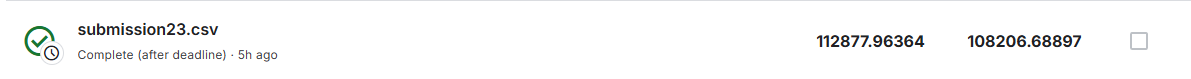

In [914]:
from IPython.display import Image, display

# 이미지 경로 설정
img_path = '/content/drive/MyDrive/aiffel/Data/sub23.png'

# 이미지 출력
display(Image(filename=img_path))

In [ ]:
# # 모델 초기화
# gboost = GradientBoostingRegressor(random_state=2020)
# lightgbm = LGBMRegressor(random_state=2020)
# rdforest = RandomForestRegressor(random_state=2020)
# xgboost = XGBRegressor(random_state=2020)

# # 하이퍼파라미터 그리드 정의
# param_grids = {
#     'gboost': {
#         'n_estimators': [150, 200, 250],
#         'max_depth': [10, 30, 50]
#     },
#     'lightgbm': {
#         'n_estimators': [150, 200, 250],
#         'max_depth': [10, 30, 50]
#     },
#     'rdforest': {
#         'n_estimators': [150, 200, 250],
#         'max_depth': [10, 30, 50]
#     }
# }

In [ ]:
# # 개별 모델의 최적 하이퍼파라미터 찾기 (K-Fold 적용)
# best_models = {}
# for name, model in zip(['gboost', 'lightgbm', 'rdforest'], [gboost, lightgbm, rdforest]):
#     print(f"Starting GridSearchCV for {name}...")
#     grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#     grid_search.fit(x_train, y_train)
#     best_models[name] = grid_search.best_estimator_
#     print(f"Best params for {name}: {grid_search.best_params_}")
#     print(f"Best RMSE for {name}: {np.sqrt(-grid_search.best_score_):.4f}")

# # 최적의 모델로 스태킹
# stack_models = [
#     ('gboost', best_models['gboost']),
#     ('lightgbm', best_models['lightgbm']),
#     ('rdforest', best_models['rdforest'])
# ]

# # 스태킹 모델 정의 (xgboost를 최종 예측기로 사용)
# stack_reg = StackingRegressor(estimators=stack_models, final_estimator=xgboost, n_jobs=-1)

# # 스태킹 모델의 K-Fold 교차 검증 (전체 성능 평가용)
# kf = KFold(n_splits=5, shuffle=True, random_state=2020)
# stack_rmse_scores = cross_val_score(stack_reg, x_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
# stack_rmse_scores = np.sqrt(-stack_rmse_scores)

# print(f"Cross-validated RMSE scores for Stacked Model: {stack_rmse_scores}")
# print(f"Mean RMSE: {stack_rmse_scores.mean():.4f}")
# print(f"Standard Deviation of RMSE: {stack_rmse_scores.std():.4f}")

# # 전체 데이터로 최종 스태킹 모델 학습
# stack_reg.fit(x_train, y_train)

# # 검증 데이터에 대한 예측 및 RMSE 확인
# stack_pred = stack_reg.predict(x_val)
# stack_rmse = rmse(y_val, stack_pred)
# print(f"Stacked Model RMSE on Validation Set: {stack_rmse:.4f}")

# # 최종 테스트 데이터에 대한 예측 및 변환
# final_pred = stack_reg.predict(x_test)
# final_pred = np.expm1(final_pred)  # 필요 시 역변환

Starting GridSearchCV for gboost...
Best params for gboost: {'max_depth': 10, 'n_estimators': 150}
Best RMSE for gboost: 0.1776
Starting GridSearchCV for lightgbm...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2334
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 43
[LightGBM] [Info] Start training from score 13.047779
Best params for lightgbm: {'max_depth': 30, 'n_estimators': 250}
Best RMSE for lightgbm: 0.1649
Starting GridSearchCV for rdforest...
Best params for rdforest: {'max_depth': 50, 'n_estimators': 250}
Best RMSE for rdforest: 0.1790
Cross-validated RMSE scores for Stacked Model: [0.17340106 0.17337478 0.17163404 0.1792787  0.17747235]
Mean RMSE: 0.